In [1]:
from utils.load_dataset import *
from utils.custom_utils import *

In [2]:
import requests

url = 'https://pytraining-bot.herokuapp.com/notify'
myobj = {'message': 'DATTI UNA SVEGLIA',
        'chat_id': '425308083'}

In [3]:
train_df = load_training(target_txt)
train_virtual, valid_virtual = split_train_valid(train_df,0.8)
weights = make_weights(train_virtual)

train_real = load_real_training(real_train_txt)
valid_real = load_real_valid(real_valid_txt)
test_df = load_testing(test_txt)

In [4]:
train.head()

img_path   x0   y0   x1   y1  label
0   split11/split11_113.png    4  116  640  283      2
1  split11/split11_1043.png   90  109  458  352      2
2  split11/split11_1118.png  107  143  640  325      2
3  split11/split11_2054.png   86  226  608  330      2
4  split11/split11_1030.png   36   80  476  312      2

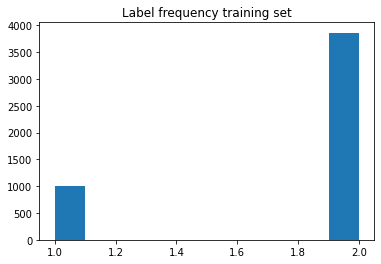

In [5]:
plt.title("Label frequency training set")
plt.hist(train['label'])
plt.show()

In [4]:
train_dataset_virtual = FallenPeople(train_virtual, DATASET, FallenPeople.train_transform())
valid_dataset_virtual = FallenPeople(valid_virtual, DATASET, FallenPeople.valid_test_transform())
test_dataset = FallenPeople(test_df, TESTING, FallenPeople.valid_test_transform())

train_dataset_real = FallenPeople(train_real, f'{REAL_DATASET}/train', FallenPeople.real_train_transform())
valid_dataset_real = FallenPeople(valid_real, f'{REAL_DATASET}/valid', FallenPeople.valid_test_transform())

In [5]:
train_len = max(len(train_dataset_virtual),len(train_dataset_real))
len_vir_t = round(train_len*float(0.7)) #split is for virtual over real
len_real_t = train_len - len_vir_t
train_vir = Subset(train_dataset_virtual, torch.randperm(len(train_dataset_virtual))[:len_vir_t])
train_real = Subset(train_dataset_real, torch.randperm(len(train_dataset_real))[:len_real_t])
#validation
valid_len = max(len(valid_dataset_virtual),len(valid_dataset_real))
len_vir_v = round(valid_len*float(0.7)) #split is for virtual over real
len_real_v = valid_len - len_vir_v
valid_vir = Subset(valid_dataset_virtual, torch.randperm(len(valid_dataset_virtual))[:len_vir_v])
valid_real = Subset(valid_dataset_real, torch.randperm(len(valid_dataset_real))[:len_real_v])
    
train_dataset = ConcatDataset([train_vir,train_real])
valid_dataset = ConcatDataset([valid_vir,valid_real])

In [ ]:
print("Some images used during training...")
random_list_fp = [random.randint(0,len(train_dataset)-1) for i in range(15)]

visualize_from_tensor_and_bb(train_dataset, random_list_fp)    

Some images used during training...


Some images used during validation...


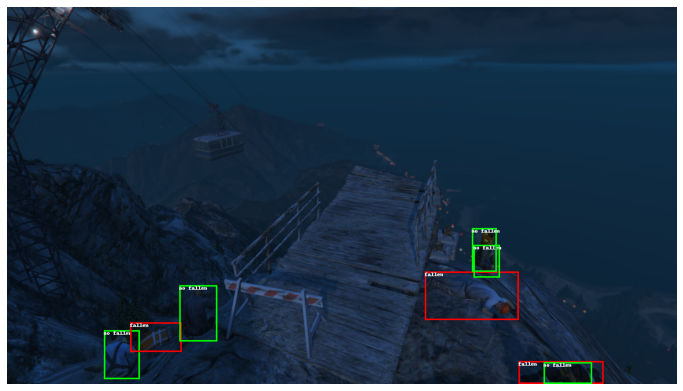

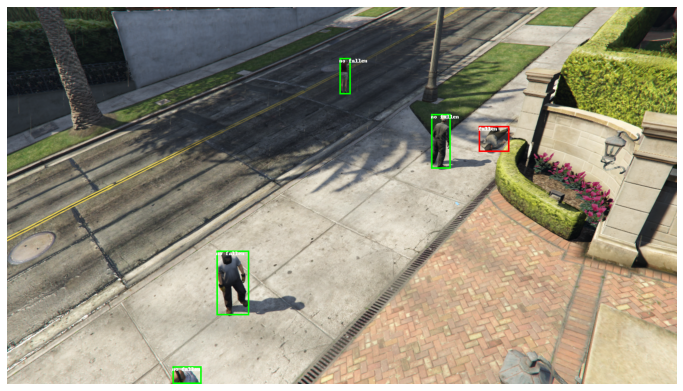

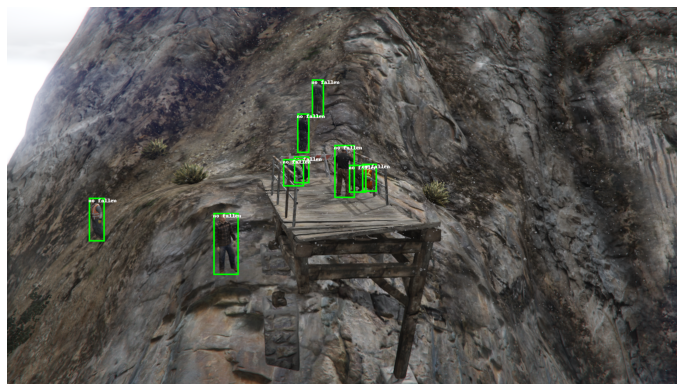

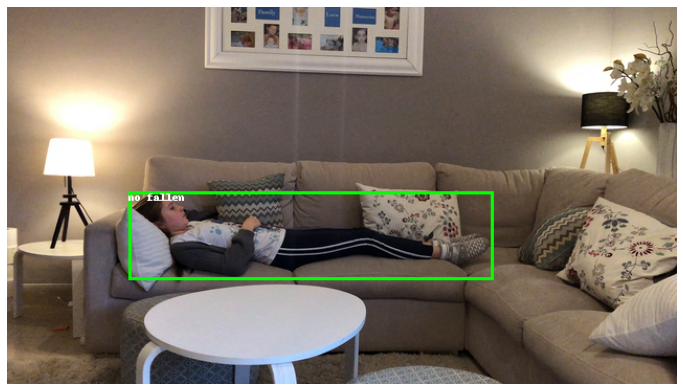

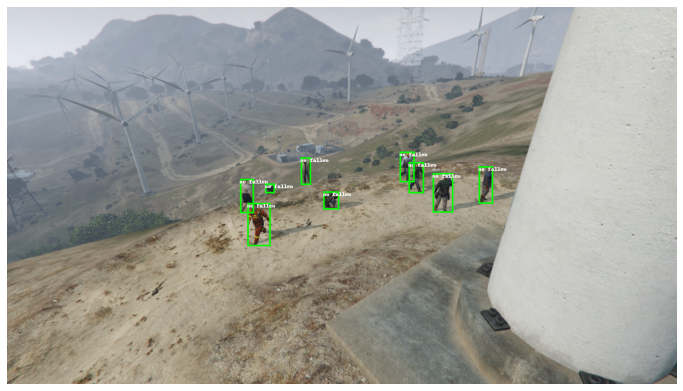

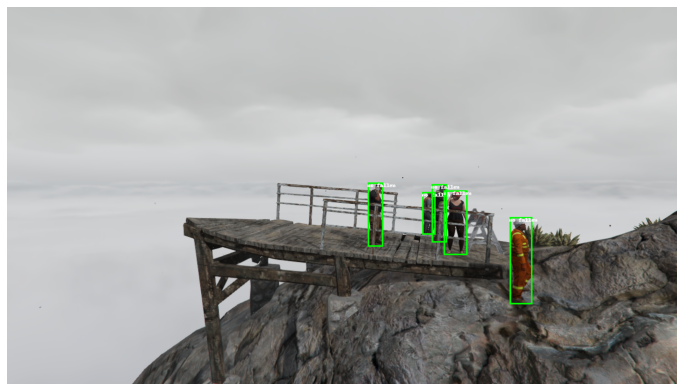

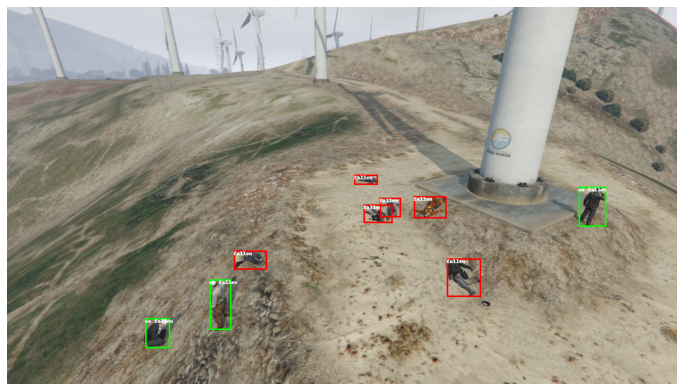

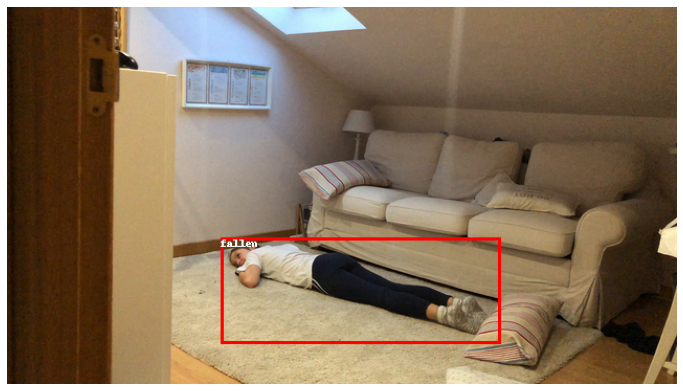

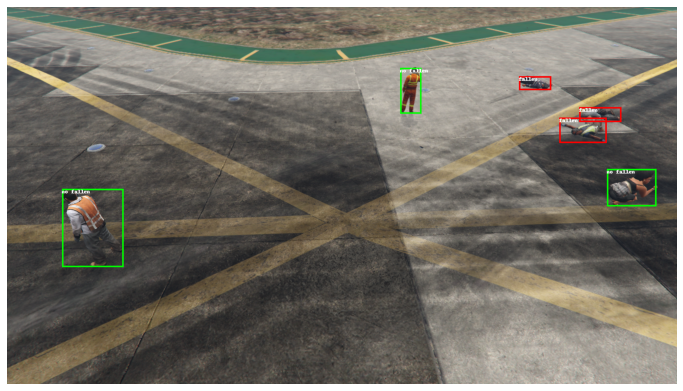

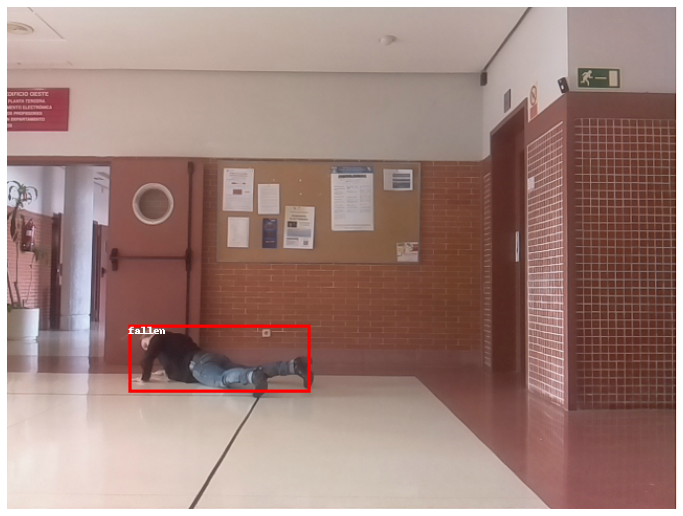

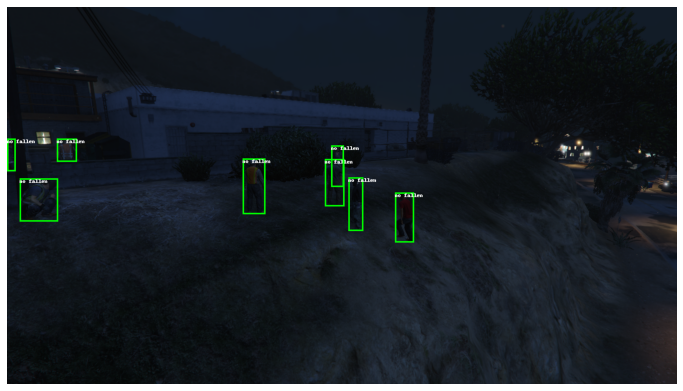

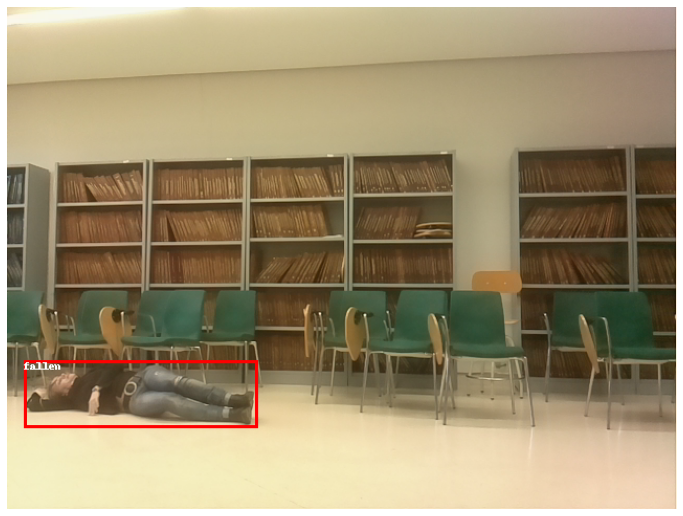

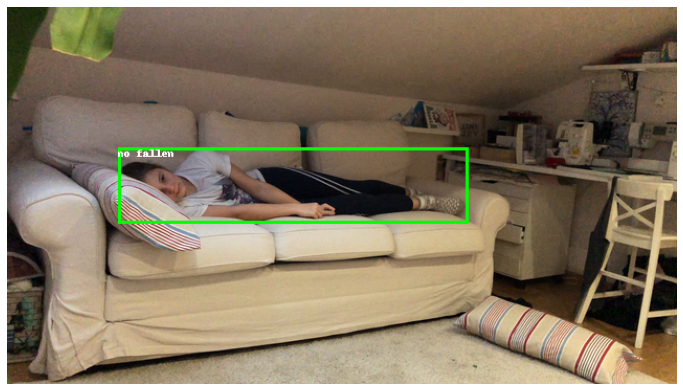

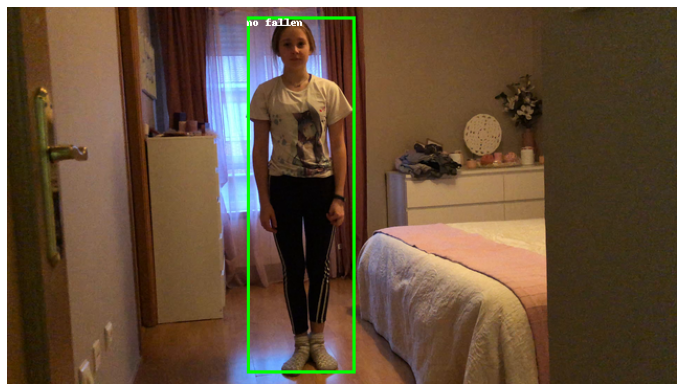

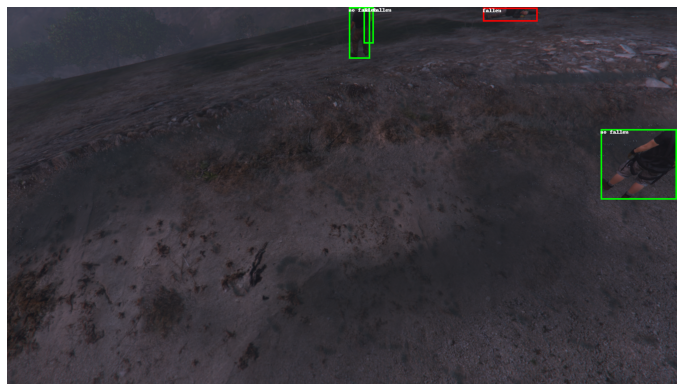

In [9]:
print("Some images used during validation...")
random_list_fp = [random.randint(0,len(valid_dataset)-1) for i in range(15)]

visualize_from_tensor_and_bb(valid_dataset, random_list_fp)    

In [8]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

# create a Faster R-CNN model without pre-trained
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

num_classes = 3 # wheat or not(background)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained model's head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# load the trained weights
model.load_state_dict(torch.load("./models/fasterrcnn_resnet50_fallen_people_v1_2021_12_020012.pth", map_location=device))

# move model to the right device
model.to(device)
print(model.roi_heads.box_predictor)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=3, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=12, bias=True)
)


In [9]:
def collate_fn(batch):
  return tuple(zip(*batch))

#sampler = torch.utils.data.WeightedRandomSampler(torch.DoubleTensor(weights), int(len(weights)))

train_data_loader = DataLoader(
  train_dataset,
  batch_size=4,
  shuffle=False,
  collate_fn=collate_fn
)

valid_data_loader = DataLoader(
  valid_dataset,
  batch_size=4,
  shuffle=False,
  collate_fn=collate_fn
)

test_data_loader = DataLoader(
  test_dataset,
  batch_size=4,
  shuffle=False,
  collate_fn=collate_fn
)

In [10]:
# create an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# create a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

# train it for 10 epochs
num_epochs = 10

In [11]:
log_txt = filename("txt","trainlogs/log_file_real_train_")

In [12]:
itr = 1

total_train_loss = []
total_valid_loss = []

losses_value = 0.0

f_log = open(log_txt, "w")
for epoch in range(num_epochs):

  start_time = time.time()

  # train ------------------------------
  running_corrects = 0

  model.train()
  train_loss = []
  pbar = tqdm(train_data_loader, desc='let\'s train')
    
  for images, targets in pbar:    

    images = list(image.to(device) for image in images)

    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    losses_value = losses.item()
    train_loss.append(losses_value)   

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    f_log.write(f"Epoch: {epoch+1}, Batch: {itr}, Loss: {losses_value}\n")
    pbar.set_description(f"Epoch: {epoch+1}, Batch: {itr}, Loss: {losses_value}")
    itr += 1
    
  epoch_train_loss = np.mean(train_loss)
  total_train_loss.append(epoch_train_loss)

  # update the learning rate
  if lr_scheduler is not None:
    lr_scheduler.step()
    
  # valid -------------------------------------

  with torch.no_grad():
    valid_loss = []
    
    for images, targets in valid_data_loader:
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
      loss_dict = model(images, targets)
      losses = sum(loss for loss in loss_dict.values())
      loss_value = losses.item()
      valid_loss.append(loss_value)
    
  epoch_valid_loss = np.mean(valid_loss)
  total_valid_loss.append(epoch_valid_loss)  

  # print losses ------------------------------
  f_log.write("\nVALIDATION PHASE... ")
  print("\nVALIDATION PHASE... ")
  f_log.write(f"Epoch Completed: {epoch+1}/{num_epochs}, Time: {time.time()-start_time}, "
        f"Train Loss: {epoch_train_loss}, Valid Loss: {epoch_valid_loss}\n")  
  print(f"Epoch Completed: {epoch+1}/{num_epochs}, Time: {time.time()-start_time}, "
        f"Train Loss: {epoch_train_loss}, Valid Loss: {epoch_valid_loss}")

  #new valid
  sys.stdout = f_log
  evaluate(model, valid_data_loader, device=device)
  sys.stdout = original_stdout

  #testing --------------------------------------
  f_log.write("\nTESTING PHASE: ")  
  print("\nTESTING PHASE... ")
  sys.stdout = f_log
  evaluate(model, test_data_loader, device=device)
  sys.stdout = original_stdout
f_log.close()
x = requests.post(url, data = myobj)

let's train:   0%|          | 0/1175 [00:00<?, ?it/s]


VALIDATION PHASE... 
Epoch Completed: 1/10, Time: 1408.2410697937012, Train Loss: 0.07533172558755316, Valid Loss: 0.11908715162552944

TESTING PHASE... 


let's train:   0%|          | 0/1175 [00:00<?, ?it/s]


VALIDATION PHASE... 
Epoch Completed: 2/10, Time: 2653.884114742279, Train Loss: 0.06518944741246548, Valid Loss: 0.12627888122434114

TESTING PHASE... 


let's train:   0%|          | 0/1175 [00:00<?, ?it/s]


VALIDATION PHASE... 
Epoch Completed: 3/10, Time: 1458.3829350471497, Train Loss: 0.06050655514318892, Valid Loss: 0.12483032360723635

TESTING PHASE... 


let's train:   0%|          | 0/1175 [00:00<?, ?it/s]


VALIDATION PHASE... 
Epoch Completed: 4/10, Time: 2019.4350337982178, Train Loss: 0.058015998411685865, Valid Loss: 0.1241691641534875

TESTING PHASE... 


let's train:   0%|          | 0/1175 [00:00<?, ?it/s]


VALIDATION PHASE... 
Epoch Completed: 5/10, Time: 1847.6773500442505, Train Loss: 0.055705762849526205, Valid Loss: 0.13380305294175537

TESTING PHASE... 


let's train:   0%|          | 0/1175 [00:00<?, ?it/s]


VALIDATION PHASE... 
Epoch Completed: 6/10, Time: 1690.2948141098022, Train Loss: 0.05506240196209004, Valid Loss: 0.13415277210780147

TESTING PHASE... 


let's train:   0%|          | 0/1175 [00:00<?, ?it/s]


VALIDATION PHASE... 
Epoch Completed: 7/10, Time: 1959.676557302475, Train Loss: 0.05429493174273917, Valid Loss: 0.12814506809829043

TESTING PHASE... 


let's train:   0%|          | 0/1175 [00:00<?, ?it/s]


VALIDATION PHASE... 
Epoch Completed: 8/10, Time: 1620.5223941802979, Train Loss: 0.054117639835210556, Valid Loss: 0.1494590619667655

TESTING PHASE... 


let's train:   0%|          | 0/1175 [00:00<?, ?it/s]


VALIDATION PHASE... 
Epoch Completed: 9/10, Time: 2007.0939891338348, Train Loss: 0.05451120345991977, Valid Loss: 0.12430608869359201

TESTING PHASE... 


let's train:   0%|          | 0/1175 [00:00<?, ?it/s]


VALIDATION PHASE... 
Epoch Completed: 10/10, Time: 2112.5951817035675, Train Loss: 0.05461313876065802, Valid Loss: 0.144770299293557

TESTING PHASE... 


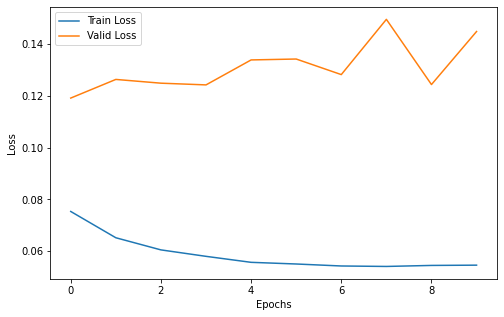

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(total_train_loss, label="Train Loss")
plt.plot(total_valid_loss, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(filename("png","snapshots/plots/train_valid_loss_real_dataset"))
plt.show()

In [ ]:
torch.save(model.state_dict(), filename("pth","models/fasterrcnn_resnet50_fallen_people_vi_real_v1_"))